NAMA : DANIEL ADITYA WARIH

LINK DATASETS : https://www.kaggle.com/lokkagle/movie-genre-data



In [ ]:
#menambahkan GPU
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
#upload file zip
from google.colab import files
files.upload()

Saving archive_13.zip to archive_13 (2).zip


In [ ]:
import os
import zipfile
import pandas as pd

#mengekstrak file
local_zip = '/content/archive_13 (2).zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()
os.listdir('/tmp/')

['debugger_1k0gguebqr',
 '__pycache__',
 'dap_multiplexer.ea923d517b41.root.log.INFO.20210823-025945.65',
 'tmpkfotfktm.py',
 'dap_multiplexer.INFO',
 'tmp3cdmvu90.py',
 'kaggle_movie_train.csv',
 'initgoogle_syslog_dir.0']

In [ ]:
df = pd.read_csv('/tmp/kaggle_movie_train.csv')
df.head()

,id,text,genre
0,0,"eady dead, maybe even wishing he was. INT. 2ND...",thriller
1,2,"t, summa cum laude and all. And I'm about to l...",comedy
2,3,"up Come, I have a surprise.... She takes him ...",drama
3,4,ded by the two detectives. INT. JEFF'S APARTME...,thriller
4,5,"nd dismounts, just as the other children reach...",drama


In [ ]:
#melihat jumlah data yang memiliki null
df.isnull().sum()

id       0
text     0
genre    0
dtype: int64

In [ ]:
#melihat jumlah genre pada setiap tipe
df[['genre']].value_counts()

genre    
drama        8873
thriller     6824
comedy       2941
action       2392
sci-fi        613
horror        456
other         270
adventure     147
romance        63
dtype: int64

In [ ]:
#Text Pre-processing/Text Cleaning
import string
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
#Menghapus Angka Pada Text
def remove_num(df):
  rn = [word for word in df if not word.isdigit()]
  return rn
df['text'] = df['text'].apply(lambda x: remove_num(x))

#menghapus punctuation
def remove_punctuation(df):
    no_punct=[words.lower() for words in df if words not in string.punctuation]
    words_wo_punct=''.join(no_punct)
    return words_wo_punct
df['text']=df['text'].apply(lambda x: remove_punctuation(x))

#tokenize
def tokenize(df):
    split=re.split("\W+",df) 
    return split
df['text']=df['text'].apply(lambda x: tokenize(x.lower()))

#stemming
def remove_stemming(df):
  ss = nltk.SnowballStemmer(language = 'english')
  w = [ss.stem(word) for word in df]
  return w
df['text'] = df['text'].apply(lambda x: remove_stemming(x))

#lemmatizer
def remove_lemme(df):
  lemmatizer = WordNetLemmatizer()
  lm = [lemmatizer.lemmatize(word) for word in df]
  return lm
df['text'] = df['text'].apply(lambda x: remove_lemme(x))

#menambahkan stopwords
def remove_stopwords(df):
    stopwords = nltk.corpus.stopwords.words('english')
    text=[word for word in df if word not in stopwords]
    return text
df['text'] = df['text'].apply(lambda x: remove_stopwords(x))

In [ ]:
df.head()

,id,text,genre
0,0,"[eadi, dead, mayb, even, wish, wa, int, nd, fl...",thriller
1,2,"[summa, cum, laud, im, launch, brand, new, mag...",comedy
2,3,"[, come, surpris, take, hand, lead, hallway, s...",drama
3,4,"[ded, two, detect, int, jeff, apart, night, me...",thriller
4,5,"[nd, dismount, child, reach, throw, themselv, ...",drama


In [ ]:
#mendrop tipe genre yang tidak akan dipakai
df = df[~df['genre'].isin(['drama','thriller','comedy','other','romance'])]
df['genre'].value_counts()

action       2392
sci-fi        613
horror        456
adventure     147
Name: genre, dtype: int64

In [ ]:
#labeling genre
category = pd.get_dummies(df.genre)
df_new = pd.concat([df, category], axis=1)
df_new = df_new.drop(columns='genre')
df_new.head()

,id,text,action,adventure,horror,sci-fi
9,11,"[e, reel, world, spin, sweat, pour, pressur, b...",1,0,0,0
32,36,"[, enter, hous, int, brownston, day, continu, ...",1,0,0,0
45,51,"[ow, could, know, father, dont, even, know, fe...",1,0,0,0
53,61,"[n, spartan, contort, defiant, sneer, face, in...",1,0,0,0
55,63,"[p, loiter, look, around, theyv, done, noth, y...",1,0,0,0


In [ ]:
#labeling untuk split
text = df_new['text'].values
label = df_new[['action',
                'adventure',
                'horror',	
                'sci-fi'
                ]].values

In [ ]:
#split
from sklearn.model_selection import train_test_split
text_train, text_test, label_train, label_test = train_test_split(text, label, test_size=0.2)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM

In [ ]:
tokenizer = Tokenizer(num_words=5000, oov_token='x')
tokenizer.fit_on_texts(text_train)
tokenizer.fit_on_texts(text_test)

sequences_latih = tokenizer.texts_to_sequences(text_train)
sequences_test = tokenizer.texts_to_sequences(text_test)

padded_latih = pad_sequences(sequences_latih)
padded_test = pad_sequences(sequences_test)

In [ ]:
import tensorflow as tf

model= tf.keras.Sequential([
                            tf.keras.layers.Embedding(input_dim=5000, output_dim=16),
                            tf.keras.layers.LSTM(64, return_sequences=True),
                            tf.keras.layers.Bidirectional(LSTM(128, return_sequences=True)),
                            tf.keras.layers.GlobalMaxPooling1D(),
                            tf.keras.layers.Dense(512, activation='relu'),
                            tf.keras.layers.Dropout(0.5),
                            tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
               metrics=['accuracy'])

In [ ]:
#menambahkan fungsi callbacks
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.9 and logs.get('val_accuracy')>0.9):
      print("\nAkurasi dan Validasi Akurasi Telah Mencapai diatas 90%!")
      self.model.stop_training = True
callbacks = myCallback()

Epoch 1/10
58/58 - 11s - loss: 0.8117 - accuracy: 0.6843 - val_loss: 0.5668 - val_accuracy: 0.7784
Epoch 2/10
58/58 - 5s - loss: 0.4100 - accuracy: 0.8174 - val_loss: 0.4625 - val_accuracy: 0.7936
Epoch 3/10
58/58 - 5s - loss: 0.2823 - accuracy: 0.8770 - val_loss: 0.4347 - val_accuracy: 0.8476
Epoch 4/10
58/58 - 5s - loss: 0.1834 - accuracy: 0.9373 - val_loss: 0.3057 - val_accuracy: 0.9100

Akurasi dan Validasi Akurasi Telah Mencapai diatas 90%!


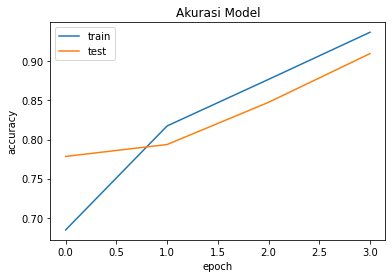

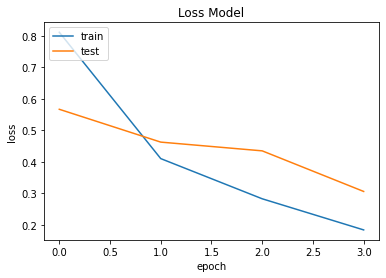

In [ ]:
num_epochs = 10
history = model.fit(padded_latih, 
                    label_train, 
                    epochs=num_epochs, 
                    validation_data=(padded_test, label_test), 
                    batch_size=50,
                    verbose=2,
                    callbacks=[callbacks])

import matplotlib.pyplot as plt
# Plot Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Plot Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()